### 构建逻辑回归分类器：以神经网络的思维方式-Pytorch实现

在2.1节中，我们提出猫咪识别的二分类问题。在本小节中，我们将通过神经网络的方法，学习如何构建一个逻辑回归分类器来识别猫咪。逻辑回归分类器是机器学习的经典工具之一，也是深度学习的基础。通过这个分类器的构建，你将对Pytorch框架有一定的了解，这为更复杂的模型打下坚实基础。



## 1 - 导入所需的包 ##

首先，运行下面的代码单元，加载将会用到的所有库。

In [1]:
# 加载numpy
import numpy as np

# 导入 torch 库，这是 PyTorch 的核心库，包含张量运算等功能
import torch

# 从 torch 中导入神经网络模块（nn），用于构建模型结构
import torch.nn as nn

# 从 torch 中导入优化器模块，用于定义损失函数和优化算法
import torch.optim as optim

# 导入 matplotlib 的 pyplot 模块，用于绘图显示图像、数据曲线
import matplotlib.pyplot as plt

# 导入 PIL 库的 Image 类，用于处理图像数据，如 JPG、PNG 格式的图像读取和转换
from PIL import Image

# 导入 scipy 库中的 ndimage 模块，用于图像处理，如旋转、滤波等（可选）
from scipy import ndimage

# 导入本地模块 lr_utils 中的 load_dataset 函数，用于加载逻辑回归用的猫图像数据集
from lr_utils import load_dataset

# 这是 Jupyter Notebook 的魔法命令：让绘图结果直接嵌入 notebook 中（非 PyTorch 特有）
# 如果你在 .py 文件中使用可以删除这行；在 Jupyter 中使用可以保留
%matplotlib inline


## 2 - 问题集概览 ##

**问题描述**：你将获得数据集，其中包含：

- 一个训练集，包含 `m_train` 张图像，每张图像被标记为猫（y=1）或非猫（y=0）；
- 一个测试集，包含 `m_test` 张图像，也同样被标记为猫或非猫；
- 每张图像的形状为 `(num_px, num_px, 3)`，其中 `3` 代表三个通道（RGB）。因此，每张图像都是正方形，高度和宽度都为 `num_px`。

你的任务是构建一个简单的图像识别算法，能够正确地将图片分类为“猫”或“非猫”。

现在，让我们更深入地了解这个数据集。运行以下代码来加载数据：

In [2]:
# 加载数据集（猫/非猫图像）
# 调用自定义的 load_dataset() 函数，返回 5 个变量：
#train_set_x_orig   训练集图像数据，格式为 (m_train, num_px, num_px, 3)，为原始 RGB 图像
#train_set_y        训练集标签，格式为 (1, m_train)，值为 0（非猫）或 1（猫）
#test_set_x_orig    测试集图像数据，格式为 (m_test, num_px, num_px, 3)，为原始 RGB 图像
#test_set_y         测试集标签，格式为 (1, m_test)，值为 0 或 1
#classes = load_dataset()  类别名称，例如 [b'non-cat', b'cat']，表示标签对应的实际类别

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

我们在训练集和测试集的图像数据集名称后添加了 "_orig" 后缀，是因为接下来将对它们进行预处理。预处理完成后，我们将得到 `train_set_x` 和 `test_set_x`。  
（标签 `train_set_y` 和 `test_set_y` 不需要任何预处理。）

你的 `train_set_x_orig` 和 `test_set_x_orig` 中的每一行都是一个表示图像的数组。  
你可以通过运行下面的代码来可视化一个图像示例。你也可以自由更改 `index` 的值并重新运行，以查看其他图像。


y = [0], it's a 'non-cat' picture.


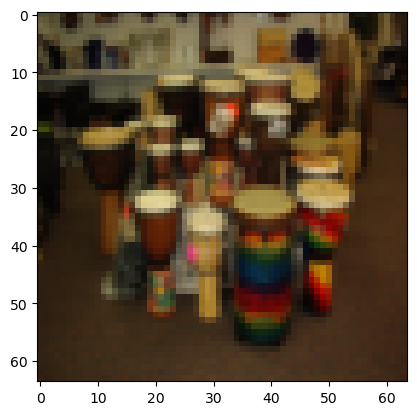

In [3]:
# 示例：显示一张训练集中第 index 张图片

index = 5  # 指定要查看训练集中第几张图像（索引从 0 开始）

# 使用 matplotlib 的 imshow 函数将该张图像显示出来
# 注意：train_set_x_orig 是 NumPy 数组，格式为 (m, num_px, num_px, 3)，可以直接用于 imshow
plt.imshow(train_set_x_orig[index])

# 输出该图像的标签和对应的文字类别
# train_set_y[:, index] 取出第 index 个图像的标签（二维数组的一列），形状为 (1,)，例如 [1] 或 [0]
# np.squeeze() 把形状为 (1,) 的数组压缩为标量，例如 1 或 0
# classes[...]：通过标签（0 或 1）取出类别名称，如 b'cat' 或 b'non-cat'
# .decode("utf-8")：将字节型的类名转为字符串，变成 'cat' 或 'non-cat'
print(
    "y = " + str(train_set_y[:, index]) +                       # 输出标签值，如 [1]
    ", it's a '" +                                              # 输出语句片段
    classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  # 输出类别名，如 'cat'
    "' picture."                                                # 输出语句片段
)


在深度学习中，很多软件错误都源于矩阵或向量的维度不匹配。如果你能够始终搞清楚矩阵/向量的维度，那么就可以避免大量的 bug。

**练习：** 找出以下变量的值：
- `m_train`：训练样本数量
- `m_test`：测试样本数量
- `num_px`：训练图像的高度或宽度（图像是正方形的，因此高度 = 宽度 = num_px）

请记住，`train_set_x_orig` 是一个形状为 `(m_train, num_px, num_px, 3)` 的 numpy 数组。例如，你可以通过 `train_set_x_orig.shape[0]` 获取 `m_train` 的值。


In [4]:
# 获取训练集图像数量（样本数），即 m_train
m_train = train_set_x_orig.shape[0]   # train_set_x_orig 的第 0 维是训练样本数量

# 获取测试集图像数量（样本数），即 m_test
m_test = test_set_x_orig.shape[0]     # test_set_x_orig 的第 0 维是测试样本数量

# 获取图像的高度（或宽度），因为图像是正方形的
num_px = train_set_x_orig.shape[1]    # 第 1 维是图像的高度（像素数）

# 获取图像的宽度（其实与高度相等）
num_py = train_set_x_orig.shape[2]    # 第 2 维是图像的宽度（像素数）

# ------------------ 打印变量以检查数据形状 ------------------

# 打印训练集样本数量
print("训练集样本数量: m_train = " + str(m_train))

# 打印测试集样本数量
print("测试集样本数量: m_test = " + str(m_test))

# 打印图像的高度（像素数）
print("图像的高度（像素数）: num_px = " + str(num_px))

# 打印每张图像的完整形状（三维：高度、宽度、RGB通道）
print("每张图像的完整形状: (" + str(num_px) + ", " + str(num_py) + ", 3)")

# 打印训练集图像的整体形状（四维张量：样本数，高度，宽度，通道）
print("训练集图像的整体形状: " + str(train_set_x_orig.shape))

# 打印训练集标签的形状
print("训练集标签的形状: " + str(train_set_y.shape))

# 打印测试集图像的整体形状
print("测试集图像的整体形状: " + str(test_set_x_orig.shape))

# 打印测试集标签的形状
print("测试集标签的形状: " + str(test_set_y.shape))


训练集样本数量: m_train = 209
测试集样本数量: m_test = 50
图像的高度（像素数）: num_px = 64
每张图像的完整形状: (64, 64, 3)
训练集图像的整体形状: (209, 64, 64, 3)
训练集标签的形状: (1, 209)
测试集图像的整体形状: (50, 64, 64, 3)
测试集标签的形状: (1, 50)


为了后续操作的方便，现在你需要将图像从形状 `(num_px, num_px, 3)` 重塑为形状 `(num_px * num_px * 3, 1)` 的张量。  
完成这一操作后，训练集（和测试集）就会变成一个pytorch张量，其中每一列代表一张被拉平的图像。  

In [5]:
# 假设 train_set_x_orig 和 test_set_x_orig 是 NumPy 数组
# 先转换成torch.Tensor，并确保类型是float32
train_set_x_orig_tensor = torch.tensor(train_set_x_orig, dtype=torch.float32)
test_set_x_orig_tensor = torch.tensor(test_set_x_orig, dtype=torch.float32)

# 将训练集图像拉平成一维向量，并转置，使形状变为 (图像像素总数, 样本数)
train_set_x_flatten = train_set_x_orig_tensor.view(train_set_x_orig_tensor.shape[0], -1).T

# 将测试集图像也进行相同处理，得到 (图像像素总数, 样本数)
test_set_x_flatten = test_set_x_orig_tensor.view(test_set_x_orig_tensor.shape[0], -1).T


# ------------------ 打印变量以检查数据形状 -----------------

print("训练集图像扁平化后的形状: " + str(train_set_x_flatten.shape))  # (num_px * num_px * 3, m_train)
print("训练集标签的形状: " + str(train_set_y.shape))                  # (1, m_train)
print("测试集图像扁平化后的形状: " + str(test_set_x_flatten.shape))    # (num_px * num_px * 3, m_test)
print("测试集标签的形状: " + str(test_set_y.shape))                    # (1, m_test)

# 拉平操作后的校验：查看训练集前5个像素的值（第0列代表第一张图片）
print("拉平操作后的校验: " + str(train_set_x_flatten[0:5, 0]))


训练集图像扁平化后的形状: torch.Size([12288, 209])
训练集标签的形状: (1, 209)
测试集图像扁平化后的形状: torch.Size([12288, 50])
测试集标签的形状: (1, 50)
拉平操作后的校验: tensor([17., 31., 56., 22., 33.])


### 图像数据标准化（Standardization）

为了表示彩色图像，每个像素必须包含红、绿、蓝（RGB）三个通道的值，因此每个像素的值实际上是一个包含三个数字的向量，这三个数字的取值范围是 0 到 255。

在机器学习中，一个常见的预处理步骤是对数据集进行居中和标准化。这意味着：  
你需要从每个样本中减去整个张量的平均值，然后将每个样本除以整个张量的标准差。

但是对于图像数据集来说，一个更简单、更方便且几乎同样有效的处理方法是：  
**将数据集中的每一行都除以 255（像素通道的最大值）**。

<!-- 
在模型训练的过程中，你将对初始输入进行加权和加偏置操作，从而得到神经元的激活值。然后你会使用梯度进行反向传播以训练模型。  
在这个过程中，非常重要的一点是：每个特征值应该具有相似的数值范围，以防止梯度爆炸。我们稍后在课程中会更详细地讲到这一点。
-->

让我们现在来对数据集进行标准化处理吧。


In [6]:
# 对训练集进行标准化处理：
# train_set_x_flatten 是一个形状为 (num_px*num_px*3, m_train) 的二维数组，
# 表示已经拉平成列向量并转置后的训练图像数据（每一列是一个样本）。
# 每个像素的值原本在 0~255 之间，我们将其除以 255，使其归一化到 0~1 之间，便于模型更好地学习。
# / 255. 中的 .0 是为了确保是浮点数除法，而不是整数除法。
# 标准化后的数据范围在 [0, 1]，这对神经网络训练非常关键，有助于避免梯度爆炸或消失的问题，加速收敛。
train_set_x = train_set_x_flatten / 255.

# 对测试集进行相同的标准化处理：
# test_set_x_flatten 是一个形状为 (num_px*num_px*3, m_test) 的二维数组，
# 每列代表一个测试样本的像素值向量，同样进行归一化处理。
test_set_x = test_set_x_flatten / 255.

In [7]:
# 降维之后的情况
print ("训练集降维后的维度: " + str(train_set_x_flatten.shape))
print ("训练集标签的维度: " + str(train_set_y.shape))
print ("测试集降维后的维度: " + str(test_set_x_flatten.shape))
print ("测试集标签的维度: " + str(test_set_y.shape))

训练集降维后的维度: torch.Size([12288, 209])
训练集标签的维度: (1, 209)
测试集降维后的维度: torch.Size([12288, 50])
测试集标签的维度: (1, 50)


<font color='blue'>

**你需要记住的要点：**
    

数据预处理的常见步骤包括：
- 确定问题的数据维度和形状（例如：`m_train`、`m_test`、`num_px` 等）
- 将数据集重塑（reshape），使得每个样本变成一个大小为 `(num_px * num_px * 3, 1)` 的向量
- 对数据进行“标准化”处理
</font>


## 3 - 学习算法的一般架构 ##

现在是设计一个简单算法来区分猫图像和非猫图像的时候了。

你将用神经网络的思维来构建一个逻辑回归模型。下图说明了为什么**逻辑回归其实是一个非常简单的神经网络！**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**算法的数学表达式**：

对于一个样本 $x^{(i)}$：
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

然后通过对所有训练样本求和来计算成本函数：
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**关键步骤**：  
在本练习中，你将完成以下步骤：  
- 初始化模型参数  
- 通过最小化成本函数学习模型参数  
- 使用学到的参数进行预测（在测试集上）  
- 分析结果并得出结论  


## 4 - 构建算法的各个部分 ##

构建神经网络的主要步骤是：  
1. 定义模型结构（例如输入特征的数量）  
2. 初始化模型参数  
3. 循环执行：  
    - 计算当前损失（前向传播）  
    - 计算当前梯度（反向传播）  
    - 更新参数（梯度下降）  

通常你会将步骤1-3分别实现，然后整合成一个我们称为 `model()` 的函数。



### 4.1 - 初始化参数

**练习：** 在下面的代码单元中实现参数初始化。你需要将权重向量 `w` 初始化为全零向。


In [8]:
def initialize_with_zeros(dim):
    """
    此函数使用 PyTorch 创建一个维度为 (dim, 1) 的全零向量 w，
    并将标量 b 初始化为 0（tensor 标量）。

    参数：
        dim -- 整数，表示我们希望 w 向量的大小（即特征数）

    返回：
        w -- PyTorch tensor，形状为 (dim, 1)，值为全 0（权重）
        b -- PyTorch tensor，标量值为 0（偏置）
    """

    # 使用 torch.zeros 创建一个形状为 (dim, 1) 的全零张量
    # dtype=torch.float32 表示使用 32 位浮点数；requires_grad=True 表示该参数需要梯度，用于后向传播
    w = torch.zeros((dim, 1), dtype=torch.float32, requires_grad=True)

    # 创建偏置项 b，为一个值为 0 的 PyTorch 标量张量，并设置 requires_grad=True 以便反向传播
    b = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

    # 断言检查：确保 w 的形状为 (dim, 1)
    assert w.shape == (dim, 1), f"w 的形状应为 ({dim}, 1)，但实际为 {w.shape}"

    # 断言检查：确保 b 是一个标量张量（0 维 tensor）
    assert b.dim() == 0, f"b 应该是一个标量张量，但实际维度为 {b.dim()}"

    # 返回初始化后的 w 和 b
    return w, b


In [9]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = tensor([[0.],
        [0.]], requires_grad=True)
b = tensor(0., requires_grad=True)



</table>

对于图像输入，w 的形状将是：  
$(\text{num\_px} \times \text{num\_px} \times 3,\ 1)$  
其中，`num_px` 表示图像的边长像素数，3 表示 RGB 三个通道。


### 4.2 - 前向传播


## 🔍 前向传播关键函数详解（PyTorch版）

以下是在 `propagate` 函数中使用的关键 PyTorch 函数，它们是实现逻辑回归中前向传播和损失计算的核心步骤。

---

### 1. `torch.mm(w.T, X)` —— 向量点积（矩阵乘法）

- **作用**：计算线性部分 $Z = w^T X + b$ 中的 $w^T X$。
- **输入维度**：
  - `w.T`：形状为 (1, n_x)，即权重向量的转置；
  - `X`：形状为 (n_x, m)，即 m 个样本，每个样本有 n_x 个特征。
- **输出维度**：
  - `z = torch.mm(w.T, X)` 的形状为 (1, m)，每个样本对应一个预测值（未激活前）。
- **示意图**：



---

### 2. `torch.sigmoid(z)` —— 激活函数

- **作用**：将线性结果 $z$ 映射到 $(0, 1)$ 区间，得到概率预测 $A$。
- **公式**：
$$
\text{sigmoid}(z) = \frac{1}{1 + e^{-z}}
$$
- **输入输出维度**：保持不变，仍为 (1, m)。

---

### 3. `A.T` —— 转置操作

- **作用**：将形状 (1, m) 的预测张量 A 转换为 (m, 1)，以与标签 `Y` 对齐，便于后续计算损失。
- **原因**：PyTorch 中的 `BCELoss` 要求输入和目标的形状完全一致。

---

### 4. `torch.nn.BCELoss()` —— 二元交叉熵损失函数

- **作用**：计算预测值 `A` 与真实标签 `Y` 之间的交叉熵损失。
- **适用于**：二分类问题（例如：猫 or 非猫）。
- **要求**：
- 输入 `A` 和目标 `Y` 都为浮点型，且形状一致（例如 (m, 1)）。
- 输入值必须是概率，即已经经过 sigmoid 函数。

---

### 5. `cost = criterion(A, Y)` —— 计算损失值

- **作用**：根据预测结果和真实标签，输出一个标量损失 `cost`。
- **意义**：损失越小，表示当前权重 w 和偏置 b 越适合模型。

---

### ✅ 总结：前向传播步骤流程图

```python
# 1. 线性部分：Z = w^T X + b
z = torch.mm(w.T, X) + b

# 2. 激活函数：A = sigmoid(Z)
A = torch.sigmoid(z)

# 3. 维度对齐：A.T 与 Y 保持一致 (m, 1)
A = A.T
Y = Y.T  # 如果有必要

# 4. 构造损失函数并计算损失
criterion = torch.nn.BCELoss()
cost = criterion(A, Y)


In [10]:
import torch

def propagate(w, b, X, Y):
    """
    PyTorch 版本的前向传播和损失计算函数，适配 torch.nn.BCELoss，确保所有输入是 Tensor 类型。

    参数说明：
        w -- 权重张量，形状为 (n_x, 1)
        b -- 偏置张量，形状为标量（或(1,)）
        X -- 输入数据张量，形状为 (n_x, m)
        Y -- 标签张量，形状为 (m, 1)，需要确保是 float 类型的 Tensor

    返回：
        cost -- 当前参数下的损失值（标量 Tensor）
    """

    # ----------- 确保所有输入为 Tensor 类型 -----------
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32)

    if not isinstance(Y, torch.Tensor):
        Y = torch.tensor(Y, dtype=torch.float32)

    if not isinstance(w, torch.Tensor):
        w = torch.tensor(w, dtype=torch.float32)

    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b, dtype=torch.float32)

    # ----------- 维度检查和调整（保持一致性） -----------
    if w.ndim == 1:
        w = w.view(-1, 1)  # 保证 w 是列向量 (n_x, 1)

    if Y.ndim == 1:
        Y = Y.view(-1, 1)  # 保证 Y 是列向量 (m, 1)

    # ----------- 前向传播计算 -----------
    z = torch.mm(w.T, X) + b             # z 形状为 (1, m)
    A = torch.sigmoid(z)                 # A 形状为 (1, m)
    
    # 转置 A 为 (m, 1)，以便与Y一致
    A = A.T
    if Y.shape != A.shape:
        Y = Y.T  # 转置Y，使其形状变为 (m, 1)

    # ----------- 创建损失函数并计算交叉熵损失 -----------
    criterion = torch.nn.BCELoss()
    cost = criterion(A, Y)               # 输入两个张量均为 (m, 1)

    return cost


In [11]:
# 变量转换为 torch.Tensor，dtype 用 float32，w,b需要requires_grad=True
w = torch.tensor([[1.0],[2.0]], dtype=torch.float32, requires_grad=True)  # (2,1)
b = torch.tensor(2.0, dtype=torch.float32, requires_grad=True)            # 标量
X = torch.tensor([[1.0, 2.0], [3.0, 4.0]], dtype=torch.float32)            # (2,2)
Y = torch.tensor([[1.0], [0.0]], dtype=torch.float32)                      # (2,1) 注意Y应该是 (m,1)

# 调用 PyTorch 版本 propagate
cost = propagate(w, b, X, Y)

print("cost = " + str(cost))


cost = tensor(5.9956, grad_fn=<BinaryCrossEntropyBackward0>)


### 4.4 反向传播与优化（Optimization）

### 🔧 PyTorch 自动求导与优化器核心函数解释

---

### 1. `torch.optim.SGD([w, b], lr=learning_rate)`

**作用**：创建一个随机梯度下降（SGD）优化器，用于更新 `w` 和 `b` 两个张量参数。通常名字为

**参数说明**：
- `[w, b]`：要被优化的参数列表，必须是 `requires_grad=True` 的张量。
- `lr`：学习率，控制每次参数更新的步长。

---

### 2. `optimizer.zero_grad()`

**作用**：将所有模型参数的梯度清零。

**背景说明**：  
PyTorch 每次执行 `.backward()` 时，梯度是**累加**的。为了避免叠加错误，必须每次迭代前调用 `zero_grad()`。

**执行时机**：在 `backward()` 前调用。

---

### 3. `cost.backward()`

**作用**：自动执行反向传播，计算损失对参数 `w` 和 `b` 的梯度。

**原理**：  
PyTorch 会根据计算图，从损失出发，一步步链式地计算所有叶子节点（如 `w`、`b`）的 `.grad`。

**结果**：  
计算完后，`w.grad` 和 `b.grad` 就包含了相应的梯度值。

---

### 4. `optimizer.step()`

**作用**：根据当前梯度更新参数。

**等价于**：

```python
w = w - learning_rate * w.grad
b = b - learning_rate * b.grad

In [12]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    用 PyTorch 自动求导和优化器实现参数优化
    """
    optimizer = torch.optim.SGD([w, b], lr=learning_rate)
    costs = []

    for i in range(num_iterations):
        optimizer.zero_grad()           # 梯度清零
        cost = propagate(w, b, X, Y)   # 前向传播计算损失
        cost.backward()                 # 自动计算梯度
        optimizer.step()                # 参数更新

        if i % 100 == 0:
            costs.append(cost.item())
            if print_cost:
                print(f"Cost after iteration {i}: {cost.item()}")

    grads = {"dw": w.grad.clone(), "db": b.grad.clone()}
    params = {"w": w, "b": b}
    return params, grads, costs


In [13]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print(costs)

w = tensor([[0.1125],
        [0.2311]], requires_grad=True)
b = tensor(1.5593, requires_grad=True)
dw = tensor([[0.9016],
        [1.7625]])
db = tensor(0.4305)
[5.995632171630859]


### 🧪 练习：实现预测函数 `predict()`

你已经有了训练完成的参数 `w` 和 `b`，接下来我们要实现预测步骤。

---

我们要使用训练得到的参数对一个输入数据集 `X` 进行预测，步骤如下：

---

### 🧮 步骤 1：前向传播，计算预测概率

$$
\hat{Y} = A = \sigma(w^T X + b)
$$

其中：
- $X$ 的维度是 `(n, m)`，即每列是一个输入样本；
- $w^T X + b$ 的输出是预测概率（每个样本属于“猫”的概率）；
- 记为 `A`

---

### 🔢 步骤 2：将激活值 `A` 转换为类别标签 0 或 1

- 如果 $a^{(i)} > 0.5$，预测为 1（是猫）；
- 如果 $a^{(i)} \leq 0.5$，预测为 0（不是猫）；


---

### 🧾 输出要求：

你要返回一个预测向量 `Y_prediction`，形状为 `(1, m)`，其中每一列都是样本的预测标签（0 或 1）。

In [14]:

def predict(w, b, X):
    """
    使用学习到的逻辑回归参数 w 和 b，对输入数据 X 进行预测（预测是否为“猫”）。

    参数说明：
        w -- 权重张量，类型为 torch.Tensor，形状为 (num_px * num_px * 3, 1)
        b -- 偏置项，类型为标量 float 或 torch.Tensor，形状为标量或 (1,)
        X -- 输入数据张量，类型为 torch.Tensor，形状为 (num_px * num_px * 3, m)，
             其中 m 是样本数，每列表示一个拉平的图像

    返回值：
        Y_prediction -- 预测结果张量，形状为 (1, m)，每个元素为 0 或 1，表示是否为“猫”
    """

    # 获取样本数量 m（即 X 的列数）
    m = X.shape[1]

    # 初始化预测结果张量，形状为 (1, m)，初始值为 0
    Y_prediction = torch.zeros((1, m), dtype=torch.float32)

    # 确保 w 的形状是 (X.shape[0], 1)，即 (n_x, 1)，防止维度不兼容
    w = w.view(X.shape[0], 1)

    # 计算每个样本的预测概率 A，公式为 A = sigmoid(w^T * X + b)
    # torch.mm 表示矩阵乘法，结果形状为 (1, m)
    A = torch.sigmoid(torch.mm(w.T, X) + b)

    # 将概率大于 0.5 的预测为 1，否则为 0
    # torch.where 是条件选择函数，第一个参数是条件表达式
    Y_prediction = torch.where(A > 0.5, torch.tensor(1.0), torch.tensor(0.0))

    # 断言预测结果形状为 (1, m)，确保结果符合预期
    assert Y_prediction.shape == (1, m)

    # 返回预测结果
    return Y_prediction


In [15]:
print ("predictions = " + str(predict(w, b, X)))

predictions = tensor([[1., 1.]])


## 5 - 合并所有函数为一个模型 ##

你现在将看到整个模型的结构方式：通过将之前实现的所有构建模块（函数）按正确的顺序组合在一起。

**练习题：** 实现一个 `model` 函数。请使用以下命名方式：
- `Y_prediction`：表示对测试集的预测结果  
- `Y_prediction_train`：表示对训练集的预测结果  
- `w`, `costs`, `grads`：表示 `optimize()` 函数的输出结果  


In [16]:
import torch

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    使用PyTorch构建的逻辑回归模型，调用已有函数进行训练与预测

    参数说明：
    X_train         - torch.Tensor，形状为 (num_px * num_px * 3, m_train)，训练特征
    Y_train         - torch.Tensor，形状为 (1, m_train)，训练标签
    X_test          - torch.Tensor，形状为 (num_px * num_px * 3, m_test)，测试特征
    Y_test          - torch.Tensor，形状为 (1, m_test)，测试标签
    num_iterations  - 训练时梯度下降的迭代次数，默认为2000（超参数）
    learning_rate   - 学习率，控制参数更新的步长，默认为0.5（超参数）
    print_cost      - 布尔值，是否每100次打印一次损失值，默认为False

    返回值：
    d - 字典，包含模型训练后的参数、预测结果、损失列表等
    """
    
    if not isinstance(X_train, torch.Tensor):
        X_train = torch.tensor(X_train, dtype=torch.float32)
    if not isinstance(Y_train, torch.Tensor):
        Y_train = torch.tensor(Y_train, dtype=torch.float32)
    if not isinstance(X_test, torch.Tensor):
        X_test = torch.tensor(X_test, dtype=torch.float32)
    if not isinstance(Y_test, torch.Tensor):
        Y_test = torch.tensor(Y_test, dtype=torch.float32)

    
    # ========== 第一步：初始化权重和偏置 ==========
    # w初始化为全0的Tensor，形状与特征维度相同；b初始化为0的标量
    w, b = initialize_with_zeros(X_train.shape[0])

    # ========== 第二步：通过梯度下降优化参数 ==========
    # 调用optimize函数（内部应使用PyTorch的autograd机制）
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # 从返回的字典中提取优化后的w和b
    w = parameters["w"]
    b = parameters["b"]
  

    # ========== 第三步：在测试集和训练集上进行预测 ==========
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)


    # ========== 第四步：计算准确率 ==========
    # 计算预测值与真实标签的差的绝对值平均值
    # 再用 100 - 平均误差（百分比）表示准确率
    train_accuracy = 100 - torch.mean(torch.abs(Y_prediction_train - Y_train)) * 100
    test_accuracy = 100 - torch.mean(torch.abs(Y_prediction_test - Y_test)) * 100

    # 打印训练集与测试集的准确率
    print("train accuracy: {} %".format(train_accuracy.item()))
    print("test accuracy: {} %".format(test_accuracy.item()))

    # ========== 第五步：打包结果 ==========
    d = {
        "costs": costs,                            # 训练过程中记录的损失列表
        "Y_prediction_test": Y_prediction_test,    # 测试集预测结果（Tensor）
        "Y_prediction_train": Y_prediction_train,  # 训练集预测结果（Tensor）
        "w": w,                                     # 学到的权重参数
        "b": b,                                     # 学到的偏置
        "learning_rate": learning_rate,             # 学习率超参数
        "num_iterations": num_iterations            # 迭代次数超参数
    }

    return d


运行下面的代码单元来训练你的模型。

In [17]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)


Cost after iteration 0: 0.6931471824645996
Cost after iteration 100: 0.5845083594322205
Cost after iteration 200: 0.46694907546043396
Cost after iteration 300: 0.3760068714618683
Cost after iteration 400: 0.3314632773399353
Cost after iteration 500: 0.3032730519771576
Cost after iteration 600: 0.2798795998096466
Cost after iteration 700: 0.26004213094711304
Cost after iteration 800: 0.24294069409370422
Cost after iteration 900: 0.22800423204898834
Cost after iteration 1000: 0.2148195058107376
Cost after iteration 1100: 0.20307819545269012
Cost after iteration 1200: 0.19254429638385773
Cost after iteration 1300: 0.18303333222866058
Cost after iteration 1400: 0.17439861595630646
Cost after iteration 1500: 0.16652138531208038
Cost after iteration 1600: 0.15930451452732086
Cost after iteration 1700: 0.1526673287153244
Cost after iteration 1800: 0.1465422362089157
Cost after iteration 1900: 0.1408720761537552
train accuracy: 99.04306030273438 %
test accuracy: 70.0 %


**注释**：训练准确率接近 100%。这是一个很好的合理性检查，说明你的模型正常工作且具有足够的能力拟合训练数据。测试误差为 68%。考虑到我们使用的是小型数据集且逻辑回归是线性分类器，对于这个简单模型来说，这个结果其实还不错。但别担心，你将构建一个更优秀的分类器！

另外，你会看到模型明显过拟合了训练数据专业后续课程中，你将学习如何减少过拟合，例如使用正则化。你可以使用下面的代码（并修改 `index` 变量）查看测试集中某张图片的预测结果。


y = 1, 你预测它是一个 "cat" 图片。


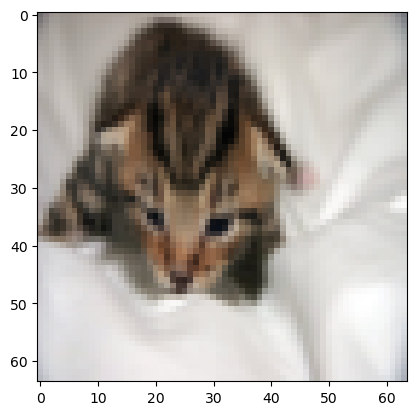

In [18]:
# 错误分类的图片示例
index = 1  # 设置要查看的图片索引

# 显示图片，reshape回原始尺寸 (num_px, num_px, 3)
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))

# 打印真实标签和预测标签
print("y = " + str(test_set_y[0, index]) + 
      ", 你预测它是一个 \"" + classes[int(d["Y_prediction_test"][0, index])].decode("utf-8") + "\" 图片。")


接下来绘制损失函数和梯度的变化曲线。

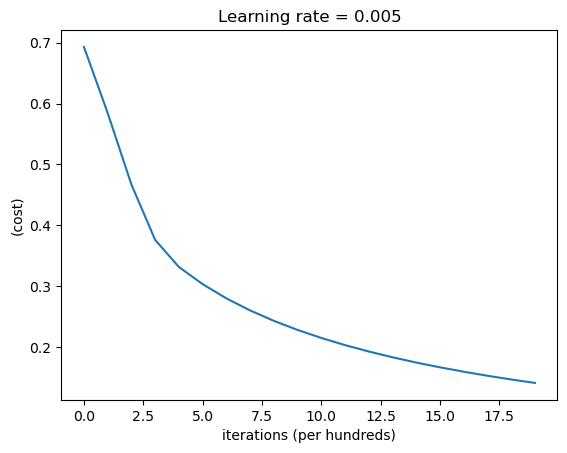

In [19]:
# 绘制学习曲线（基于成本函数）
costs = np.squeeze(d['costs'])  # 将成本数组降维，变成一维数组
plt.plot(costs)                 # 绘制成本随迭代次数的变化曲线
plt.ylabel('(cost)')        # y轴标签
plt.xlabel('iterations (per hundreds)')  # x轴标签
plt.title("Learning rate = " + str(d["learning_rate"]))  # 标题，显示学习率
plt.show()                      # 显示图形


**解读**：  
你可以看到成本在不断下降，这表明模型参数正在被有效学习。然而，你也会发现可以通过增加迭代次数来进一步训练模型。试着将上面代码单元中的迭代次数增加，然后重新运行相关代码。你可能会看到训练集的准确率提高，但测试集的准确率下降，这种现象称为过拟合。


## 6 - 进一步分析 ##

恭喜你完成了第一个图像分类模型的构建。接下来我们对它进行更深入的分析，并探讨学习率 $\alpha$ 的可能选择。


#### 学习率的选择 ####

**提醒**：  
为了使梯度下降法有效，你必须明智地选择学习率。学习率 $\alpha$ 决定了参数更新的速度。  
如果学习率过大，可能会导致“超调”最优值；同样，如果学习率过小，则需要太多的迭代次数才能收敛到最佳值。  
这就是为什么使用一个调优良好的学习率非常关键。

下面我们来比较模型在不同学习率下的学习曲线。运行下面的代码单元，耗时大约1分钟。  
你也可以尝试不同于初始化时 `learning_rates` 变量中三个值的其它学习率，看看结果会怎样。


learning rate is: 0.01
train accuracy: 99.52153015136719 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.9952163696289 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105102539062 %
test accuracy: 36.0 %

-------------------------------------------------------



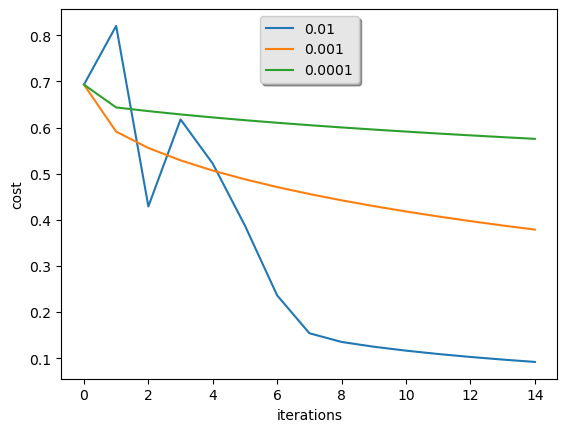

In [20]:
learning_rates = [0.01, 0.001, 0.0001]  # 定义一个列表，包含3个不同的学习率值

models = {}  # 创建一个空字典，用于存储不同学习率对应的训练模型结果

for i in learning_rates:  # 遍历每一个学习率
    print("learning rate is: " + str(i))  # 输出当前的学习率，方便观察

    # 调用 model 函数训练模型
    # 参数说明：
    # train_set_x -- 训练集特征数据
    # train_set_y -- 训练集标签
    # test_set_x -- 测试集特征数据
    # test_set_y -- 测试集标签
    # num_iterations=1500 -- 训练迭代次数设为1500
    # learning_rate=i -- 当前循环的学习率
    # print_cost=False -- 不打印训练过程中的成本信息
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y,
                          num_iterations=1500,
                          learning_rate=i,
                          print_cost=False)

    print('\n' + "-------------------------------------------------------" + '\n')  # 输出分割线，便于区分不同学习率的训练结果

# 画图部分：遍历所有学习率，画出对应模型的成本曲线
for i in learning_rates:
    # np.squeeze 用于去除多余的维度，models[str(i)]["costs"] 是训练过程中记录的成本列表
    # label 参数为图例标签，显示当前学习率
    plt.plot(np.squeeze(models[str(i)]["costs"]), label=str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')       # 设置y轴标签为 cost（成本）
plt.xlabel('iterations') # 设置x轴标签为 iterations（迭代次数）

# 设置图例显示位置为上方中央，添加阴影
legend = plt.legend(loc='upper center', shadow=True)

frame = legend.get_frame()  # 获取图例的边框属性
frame.set_facecolor('0.90') # 设置图例背景颜色为灰白色（亮度0.90）

plt.show()  # 显示绘制好的图形


**解读**：  
- 不同的学习率会导致不同的成本（cost）和不同的预测结果。  
- 如果学习率过大（如0.01），成本可能会出现上下波动，甚至可能发散（不过在本例中，使用0.01的学习率最终仍能收敛到较好的成本值）。  
- 更低的成本不一定意味着模型更好，你还需要检查是否存在过拟合的情况。过拟合表现为训练集准确率远高于测试集准确率。  
- 在深度学习中，我们通常建议：  
    - 选择能够更好地最小化成本函数的学习率。  
    - 如果模型出现过拟合，采用其他技术来减少过拟合。内容会在后续视频中讲解。）  


<font color='blue'>  
  
**要点回顾：**  
    
1. 对数据集进行预处理非常重要。  
2. 你分别实现了各个函数：initialize()、propagate()、optimize()，然后构建了一个完整的 model()。  
3. 调整学习率（作为一种“超参数”）对算法效果影响很大。你将在后续看到更多此类示例！  
</font>